### **Liver Disease Patient Dataset**

**Data set:**

The data Set contains 20K train data, ~1K Test data.

This data set contains 10 variables that are age, gender, total Bilirubin, direct Bilirubin, total proteins, albumin, A/G ratio, SGPT, SGOT and Alkphos.



From the website of Mount Sinai hospital we collected the data of the normal results of each feature.

https://www.mountsinai.org/health-library

**Attribute Information:**

1. Age - the age of the patient
2. Gender -  the gender of the patient
3. TB  - Total Bilirubin. This is a blood test that measures the amount of a substance called bilirubin. This test is used to find out how well your liver is working. It is often part of a panel of tests that measure liver function. A small amount of bilirubin in your blood is normal, but a high level may be a sign of liver disease. <br>
The normal range is between 0.1 to 1.2 mg/dL 
4. DB - Direct Bilirubin. <br>
The normal range is less than 0.3 mg/dL
5. Alkphos - Alkaline Phosphotas. <br>
The normal range is between 44 to 147 international units per literת IU/L
6. Sgpt - Alanine Aminotransferase, An enzyme found in the liver and other tissues. <br>
The normal range is between 4 to 36 U/L.
7. Sgot - Aspartate Aminotransferase also an enzyme found in the liver.  <br>
The normal range is between 8 to 33 U/L.
8. TP - Total Proteins. <br>
The normal range between is 6.0 to 8.3 grams per deciliterת g/dL
9. ALB - Albumin. <br>
The normal range is between 3.4 to 5.4 g/dL 
10. A/G  - The Ratio Albumin and Globulin Ratio. It measures the ratio of albumin to globulin, the two main proteins in your blood. The normal range for albumin/globulin ratio is over 1 Source, usually around 1 to 2. That’s because there’s a bit more albumin than globulin in serum protein.

Selector field used to split the data into two sets (labeled by the experts) 1 Liver Patient, 2 non Liver Patient we transformed the 2 into zero for convenience mesures later on)

### Install relevant packages

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Imports

In [ ]:
# Import other modules not related to PySpark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import accuracy_score
import warnings
sns.set_style('darkgrid')
%matplotlib inline

In [ ]:
# Import PySpark related modules
import pyspark as sp
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql import SQLContext
from pyspark.sql import functions

import pyspark.sql.functions as func
from pyspark.sql.functions import lit,mean, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, when, sum,avg,max,count
from pyspark.ml.feature import Bucketizer
from pyspark.sql.types import *
from pyspark.sql.functions import col, count, mean
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [ ]:
warnings.filterwarnings('ignore')

### Set up spark environment

In [ ]:
# Initialize a spark session
sc = sp.SparkContext.getOrCreate()
print(sc)
print(sc.version)

<SparkContext master=local[*] appName=pyspark-shell>
3.3.2


### Start Spark Session

In [ ]:
# create a SparkSession
spark = SparkSession.builder.appName("Liver Patient Prediction").getOrCreate()

## Read datasets

In [ ]:
# load the CSV file as a DataFrame
file_path = "Liver Patient Dataset (LPD)_train - Liver Patient Dataset (LPD)_train.csv"
df = spark.read.format("csv").option("header", True).option("inferSchema", True).load(file_path)

## **Overview of Dataset**

### Data Pre-Processing

In [ ]:
type(df)

pyspark.sql.dataframe.DataFrame

In [ ]:
# Check the data types of the columns in the DataFrame
df.printSchema()

root
 |-- Age of the patient: integer (nullable = true)
 |-- Gender of the patient: string (nullable = true)
 |-- Total Bilirubin: double (nullable = true)
 |-- Direct Bilirubin: double (nullable = true)
 |--  Alkphos Alkaline Phosphotase: integer (nullable = true)
 |--  Sgpt Alamine Aminotransferase: integer (nullable = true)
 |-- Sgot Aspartate Aminotransferase: integer (nullable = true)
 |-- Total Protiens: double (nullable = true)
 |--  ALB Albumin: double (nullable = true)
 |-- A/G Ratio Albumin and Globulin Ratio: double (nullable = true)
 |-- Result: integer (nullable = true)



In [ ]:
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,Age of the patient,int
1,Gender of the patient,string
2,Total Bilirubin,double
3,Direct Bilirubin,double
4,Alkphos Alkaline Phosphotase,int
5,Sgpt Alamine Aminotransferase,int
6,Sgot Aspartate Aminotransferase,int
7,Total Protiens,double
8,ALB Albumin,double
9,A/G Ratio Albumin and Globulin Ratio,double


### Set coulmns names

In [ ]:
# Change the coulms names 
Columns = ["age","gender","TB","DB","AAP","SgptAA","SgotAA","TP","ALBA","A/G ratio","target"]
df = df.toDF(*Columns)
df.show()

+---+------+----+---+---+------+------+---+----+---------+------+
|age|gender|  TB| DB|AAP|SgptAA|SgotAA| TP|ALBA|A/G ratio|target|
+---+------+----+---+---+------+------+---+----+---------+------+
| 65|Female| 0.7|0.1|187|    16|    18|6.8| 3.3|      0.9|     1|
| 62|  Male|10.9|5.5|699|    64|   100|7.5| 3.2|     0.74|     1|
| 62|  Male| 7.3|4.1|490|    60|    68|7.0| 3.3|     0.89|     1|
| 58|  Male| 1.0|0.4|182|    14|    20|6.8| 3.4|      1.0|     1|
| 72|  Male| 3.9|2.0|195|    27|    59|7.3| 2.4|      0.4|     1|
| 46|  Male| 1.8|0.7|208|    19|    14|7.6| 4.4|      1.3|     1|
| 26|Female| 0.9|0.2|154|  null|    12|7.0| 3.5|      1.0|     1|
| 29|Female| 0.9|0.3|202|    14|    11|6.7| 3.6|      1.1|     1|
| 17|  Male| 0.9|0.3|202|    22|    19|7.4| 4.1|      1.2|     2|
| 55|  Male| 0.7|0.2|290|    53|    58|6.8| 3.4|      1.0|     1|
| 57|  Male| 0.6|0.1|210|    51|    59|5.9| 2.7|      0.8|     1|
| 72|  Male| 2.7|1.3|260|    31|    56|7.4| 3.0|      0.6|     1|
| 64|  Mal

## **Detect missing values and abnormal zeroes**

### Start by checking the total number of rows we have 

In [ ]:
# Check the number of rows and columns in the DataFrame
print("Number of rows: ", df.count())
print("Number of columns: ", len(df.columns))

Number of rows:  30691
Number of columns:  11


In [ ]:
df.groupby('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1|21917|
|     2| 8774|
+------+-----+



Change the target numbers to be 0/1 instead of 2/1 where:

1 - Diagnosed with liver disease 

0 - Is not diagnosed with liver disease 

In [ ]:
df = df.withColumn('target', when(df.target == 2,0).otherwise(df.target))
df.groupby('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1|21917|
|     0| 8774|
+------+-----+



After having a first sight of the columns, the first thing we should check is if the data set having any missing value.

*   For string columns, we check for None and null
*   For numeric columns, we check for zeroes and NaN

In [ ]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,age,int
1,gender,string
2,TB,double
3,DB,double
4,AAP,int
5,SgptAA,int
6,SgotAA,int
7,TP,double
8,ALBA,double
9,A/G ratio,double


### Handle missing data

In [ ]:
# Check the number of missing values in each column of the DataFrame
string_columns = ['gender']
numeric_columns = ['age','gender','TB','DB','AAP','SgptAA','SgotAA','TP','ALBA','A/G ratio','target']
missing_values = {} 

for index, column in enumerate(df.columns):
    if column in string_columns:    # check string columns with None and Null values
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isNull()).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,age,gender,TB,DB,AAP,SgptAA,SgotAA,TP,ALBA,A/G ratio,target
0,2,902,648,561,796,538,462,463,494,559,0


We will handle missing data as follows:
* Because gender is a categorical feature we will remove the missing data (it is less then 3% of the data) Thw same goes to age where there are 2 rows with missing data so we will remove them as well.
* For the nomerical features we will two options to. remove the data and take the risk of losing data or replace the null values with other value. We choose to replace the null values with the mean of each feature and with that we will not lose any data. 

We will start with gender and age, first we will remove all null values and then we will convert it into inderxer:

In [ ]:
# Remove null values from gender and age
df = df.filter(df.gender.isNotNull())
df = df.filter(df.age.isNotNull())

print("Number of current rows: ", df.count())

Number of current rows:  29787


In [ ]:
# Convert the "gender" column to a numeric type using StringIndexer
indexer = StringIndexer(inputCol="gender", outputCol="genderIndex")
df = indexer.fit(df).transform(df)
df = df.withColumn("genderIndex", func.round(df["genderIndex"], 2).cast('integer'))

# Check the data types of the columns in the DataFrame again
df.printSchema()

df.show(5)

root
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- TB: double (nullable = true)
 |-- DB: double (nullable = true)
 |-- AAP: integer (nullable = true)
 |-- SgptAA: integer (nullable = true)
 |-- SgotAA: integer (nullable = true)
 |-- TP: double (nullable = true)
 |-- ALBA: double (nullable = true)
 |-- A/G ratio: double (nullable = true)
 |-- target: integer (nullable = true)
 |-- genderIndex: integer (nullable = true)

+---+------+----+---+---+------+------+---+----+---------+------+-----------+
|age|gender|  TB| DB|AAP|SgptAA|SgotAA| TP|ALBA|A/G ratio|target|genderIndex|
+---+------+----+---+---+------+------+---+----+---------+------+-----------+
| 65|Female| 0.7|0.1|187|    16|    18|6.8| 3.3|      0.9|     1|          1|
| 62|  Male|10.9|5.5|699|    64|   100|7.5| 3.2|     0.74|     1|          0|
| 62|  Male| 7.3|4.1|490|    60|    68|7.0| 3.3|     0.89|     1|          0|
| 58|  Male| 1.0|0.4|182|    14|    20|6.8| 3.4|      1.0|     1|          0

In [ ]:
# Drop the original "gender" column and keep only the "genderIndex" column
df = df.drop("gender").withColumnRenamed("genderIndex", "gender")
df.show(5)

+---+----+---+---+------+------+---+----+---------+------+------+
|age|  TB| DB|AAP|SgptAA|SgotAA| TP|ALBA|A/G ratio|target|gender|
+---+----+---+---+------+------+---+----+---------+------+------+
| 65| 0.7|0.1|187|    16|    18|6.8| 3.3|      0.9|     1|     1|
| 62|10.9|5.5|699|    64|   100|7.5| 3.2|     0.74|     1|     0|
| 62| 7.3|4.1|490|    60|    68|7.0| 3.3|     0.89|     1|     0|
| 58| 1.0|0.4|182|    14|    20|6.8| 3.4|      1.0|     1|     0|
| 72| 3.9|2.0|195|    27|    59|7.3| 2.4|      0.4|     1|     0|
+---+----+---+---+------+------+---+----+---------+------+------+
only showing top 5 rows



In [ ]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

Data frame describe (string and numeric columns only):


,summary,age,TB,DB,AAP,SgptAA,SgotAA,TP,ALBA,A/G ratio,target,gender
0,count,29787,29368,29328,29061,29306,29378,29365,29332,29270,29787,29787
1,mean,44.12774028938799,3.3739274039771328,1.5282255864700809,289.4403496094422,81.38623490070293,111.46538225883315,6.480606163800408,3.1292342833764852,0.9430662794670305,0.7148420451874979,0.2619599153993353
2,stddev,15.98073118352127,6.255686815781422,2.871033624502167,239.00715547101862,181.89840787318502,279.95395225388336,1.0816572787527479,0.7924338262134138,0.3232188939854091,0.45149721948244803,0.4397083226284811
3,min,4,0.4,0.1,63,10,10,2.7,0.9,0.3,0,0
4,max,90,75.0,19.7,2110,2000,4929,9.6,5.5,2.8,1,1


For the nomerical features we will replace the null values with the mean of the feature:

In [ ]:
# df_avg is a list of all the features mean or average values
df_avg = df.select(mean('age'), mean('TB'), mean('DB'), mean('AAP'), mean('SgptAA'), mean('SgotAA'), mean('TP'), mean('ALBA'), mean('A/G ratio')).collect()

#filling numeric column values with the mean or average value of that particular column
df = df.fillna({'age':df_avg[0][0],'TB':df_avg[0][1],'DB':df_avg[0][2],'AAP':df_avg[0][3],'SgptAA':df_avg[0][4],'SgotAA':df_avg[0][5],'TP':df_avg[0][6],'ALBA':df_avg[0][7],'A/G ratio':df_avg[0][8]})
df.show(5)

+---+----+---+---+------+------+---+----+---------+------+------+
|age|  TB| DB|AAP|SgptAA|SgotAA| TP|ALBA|A/G ratio|target|gender|
+---+----+---+---+------+------+---+----+---------+------+------+
| 65| 0.7|0.1|187|    16|    18|6.8| 3.3|      0.9|     1|     1|
| 62|10.9|5.5|699|    64|   100|7.5| 3.2|     0.74|     1|     0|
| 62| 7.3|4.1|490|    60|    68|7.0| 3.3|     0.89|     1|     0|
| 58| 1.0|0.4|182|    14|    20|6.8| 3.4|      1.0|     1|     0|
| 72| 3.9|2.0|195|    27|    59|7.3| 2.4|      0.4|     1|     0|
+---+----+---+---+------+------+---+----+---------+------+------+
only showing top 5 rows



In [ ]:
# Checking once again that we are not left with any null value
string_columns = ['gender']
numeric_columns = ['age','gender','TB','DB','AAP','SgptAA','SgotAA','TP','ALBA','A/G ratio','target']
missing_values = {} 

for index, column in enumerate(df.columns):
    if column in string_columns:    # check string columns with None and Null values
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isNull()).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,age,TB,DB,AAP,SgptAA,SgotAA,TP,ALBA,A/G ratio,target,gender
0,0,0,0,0,0,0,0,0,0,0,0


### **Exploratory Data Analysis - EDA**

### One-dimensional analysis

To perform a one-dimensional analysis, value ranges must be grouped for each parameter.

Performing regressions and analyzes based on categorical variables has several notable advantages:


*   Ability to detect non-linear relationships (such as age: it is possible that borrowers aged 35-45 are the most dangerous).
*   Effect of extreme cases and treatment of missing values.
*   The possibility to translate the results into a Scorecard.




The grouping is performed according to two considerations:

*   Statistical consideration 
*   Business consideration


After grouping into categories in each feature, a statistical test for the significance of the categories will be performed.
And after dividing the feature into categories, the relationship between the risk characteristic (feature) and the failure component (target) will be examined.


There are several types of connections that can be found:

*   **Straight relationship** - the chance of failure increases with the increase in the value of the risk characteristic.
*   **Inverse relationship** - the chance of failure decreases with the increase in the value of the risk characteristic.
*   **Bidirectional relationship** - as you move away from the average value of the parameter, the chance of failure increases / decreases.
*   **There is no relationship** - no clear trend is identified - a uniform distribution of the chance of failure at each value of the risk characteristic.



### Segmentation

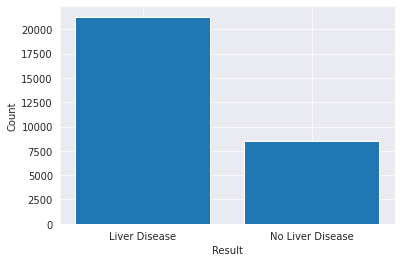

Number of patients diagnosed with liver disease: 21293
Number of patients not diagnosed with liver disease: 8494


In [ ]:
# Group the DataFrame by the "target" column and count the occurrences of each value
result_counts = df.groupBy("target").agg(F.count("*").alias("count")).orderBy("target")

# Extract the counts of each value
ld_count = result_counts.filter(result_counts.target == 1).select("count").collect()[0][0]
nld_count = result_counts.filter(result_counts.target == 0).select("count").collect()[0][0]

# Plot the counts using Matplotlib
plt.bar(["Liver Disease", "No Liver Disease"], [ld_count, nld_count])
plt.xlabel("Result")
plt.ylabel("Count")
plt.show()

# Print the number of patients in each class
print("Number of patients diagnosed with liver disease:", ld_count)
print("Number of patients not diagnosed with liver disease:", nld_count)

Gender distribution check

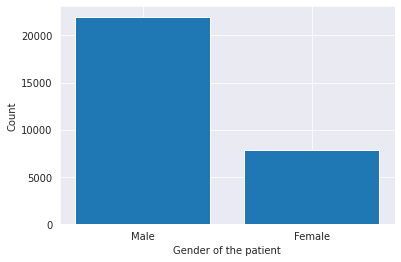

Number of patients that are male: 21984
Number of patients that are female: 7803


In [ ]:
# Group the DataFrame by the "genderindexcolom" column and count the occurrences of each value
gender_counts = df.groupBy("gender").agg(F.count("*").alias("count")).orderBy("gender")

# Extract the counts of each value
male_count = gender_counts.filter(gender_counts.gender == 0).select("count").collect()[0][0]
female_count = gender_counts.filter(gender_counts.gender == 1).select("count").collect()[0][0]

# Plot the counts using Matplotlib
plt.bar(["Male", "Female"], [male_count, female_count])
plt.xlabel("Gender of the patient")
plt.ylabel("Count")
plt.show()

# Print the number of patients in each class
print("Number of patients that are male:", male_count)
print("Number of patients that are female:", female_count)

Grouping both distribution together

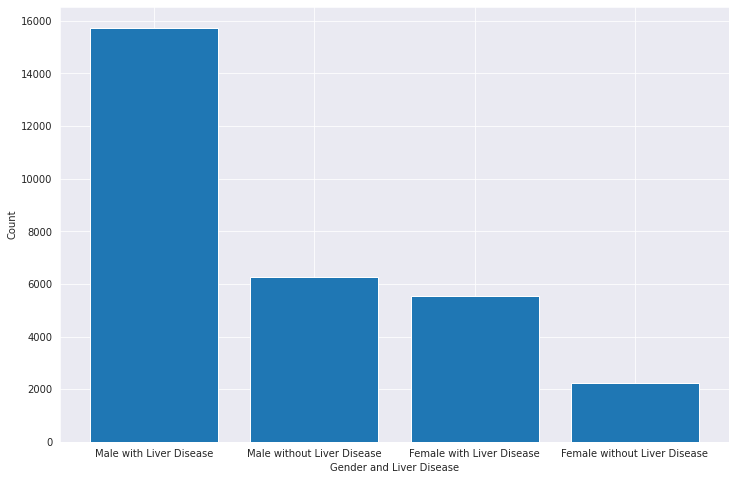

Number of male patients diagnosed with liver disease: 15740
Number of male patients not diagnosed with liver disease: 6244
Number of female patients diagnosed with liver disease: 5553
Number of female patients not diagnosed with liver disease: 2250


In [ ]:
# Group the DataFrame by the "gender" and "target" columns and count the occurrences of each value
gender_result_counts = df.groupBy("gender", "target").agg(F.count("*").alias("count")).orderBy("gender")

# Extract the counts of each value
male_ld_count = gender_result_counts.filter((col("gender") == 0) & (col("target") == 1)).select("count").collect()[0][0]
male_nld_count = gender_result_counts.filter((col("gender") == 0) & (col("target") == 0)).select("count").collect()[0][0]
female_ld_count = gender_result_counts.filter((col("gender") == 1) & (col("target") == 1)).select("count").collect()[0][0]
female_nld_count = gender_result_counts.filter((col("gender") == 1) & (col("target") == 0)).select("count").collect()[0][0]

# Plot the results using Matplotlib
plt.figure(figsize=(12, 8)) 
labels = ['Male with Liver Disease', 'Male without Liver Disease', 'Female with Liver Disease', 'Female without Liver Disease']
counts = [male_ld_count, male_nld_count, female_ld_count, female_nld_count]
plt.bar(labels, counts)
plt.xlabel("Gender and Liver Disease")
plt.ylabel("Count")
plt.show()

# Print the number of patients in each class
print("Number of male patients diagnosed with liver disease:", male_ld_count)
print("Number of male patients not diagnosed with liver disease:", male_nld_count)
print("Number of female patients diagnosed with liver disease:", female_ld_count)
print("Number of female patients not diagnosed with liver disease:", female_nld_count)

From the analysis above, we can see that there are much more males than females in the data.

We want to check if there is an impact on the prediction if a patient has liver disease or not for each of the features

### Boxplots for each feature and the impact of spliting the gender into female and male

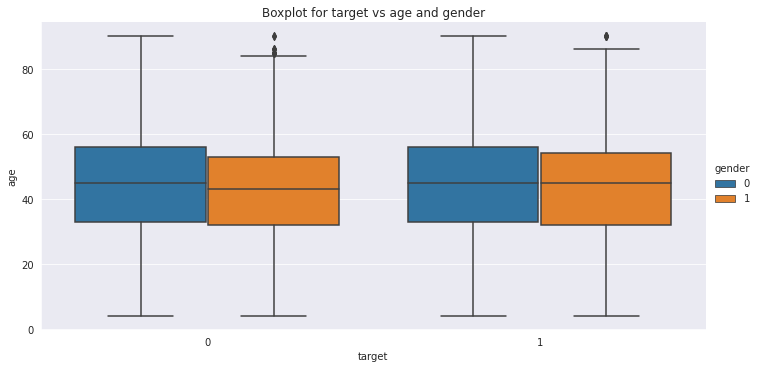

In [ ]:
# Box plot for age 
sns.catplot(data=df.toPandas(), x="target", y="age", hue="gender", kind="box", aspect=2)
plt.title("Boxplot for target vs age and gender")
plt.show()

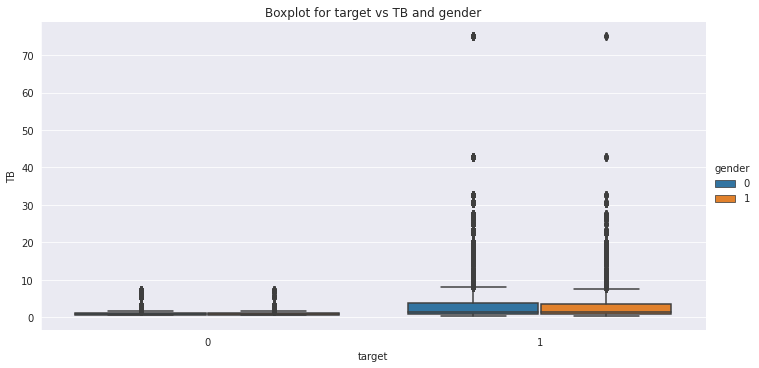

In [ ]:
# Box plot for TB 
sns.catplot(data=df.toPandas(), x="target", y="TB", hue="gender", kind="box", aspect=2)
plt.title("Boxplot for target vs TB and gender")
plt.show()

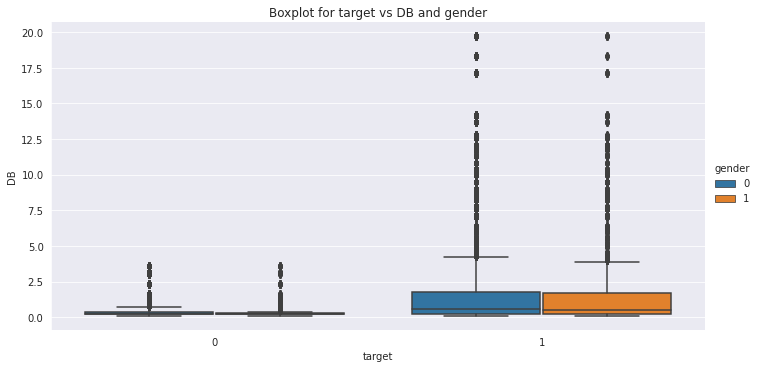

In [ ]:
# Box plot for DB 
sns.catplot(data=df.toPandas(), x="target", y="DB", hue="gender", kind="box", aspect=2)
plt.title("Boxplot for target vs DB and gender")
plt.show()

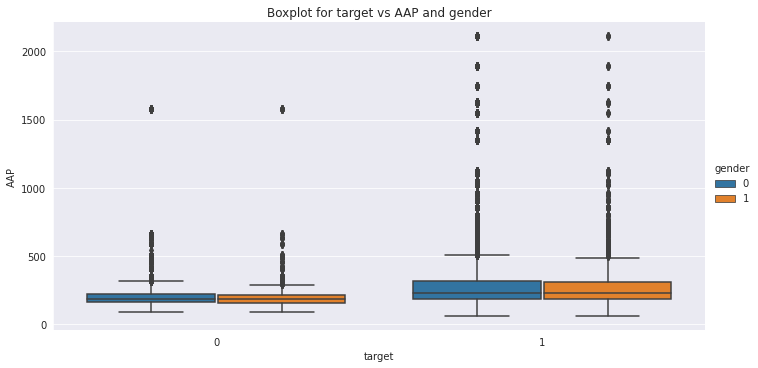

In [ ]:
# Box plot for AAP 
sns.catplot(data=df.toPandas(), x="target", y="AAP", hue="gender", kind="box", aspect=2)
plt.title("Boxplot for target vs AAP and gender")
plt.show()

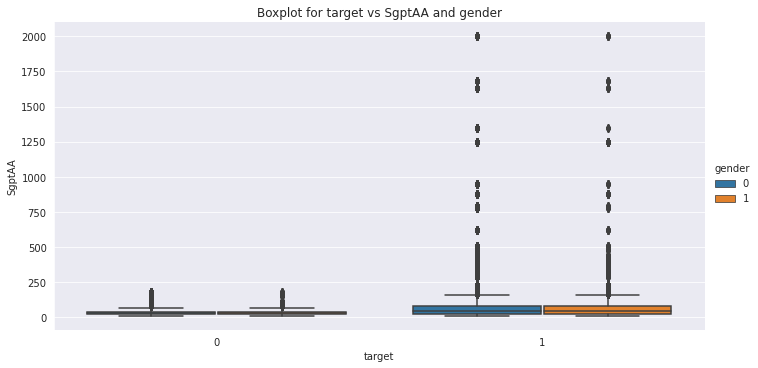

In [ ]:
# Box plot for SgptAA 
sns.catplot(data=df.toPandas(), x="target", y="SgptAA", hue="gender", kind="box", aspect=2)
plt.title("Boxplot for target vs SgptAA and gender")
plt.show()

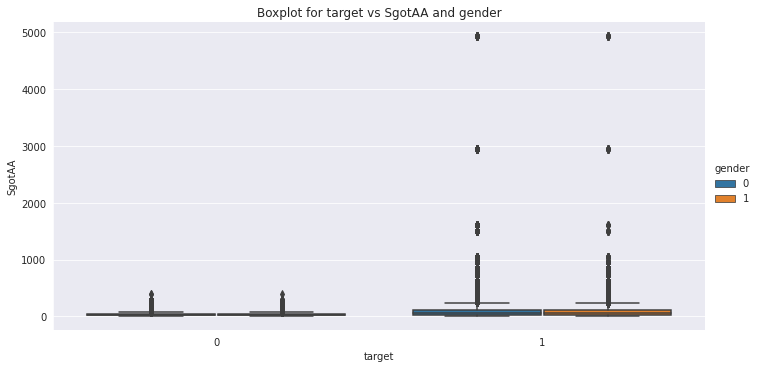

In [ ]:
# Box plot for SgotAA 
sns.catplot(data=df.toPandas(), x="target", y="SgotAA", hue="gender", kind="box", aspect=2)
plt.title("Boxplot for target vs SgotAA and gender")
plt.show()

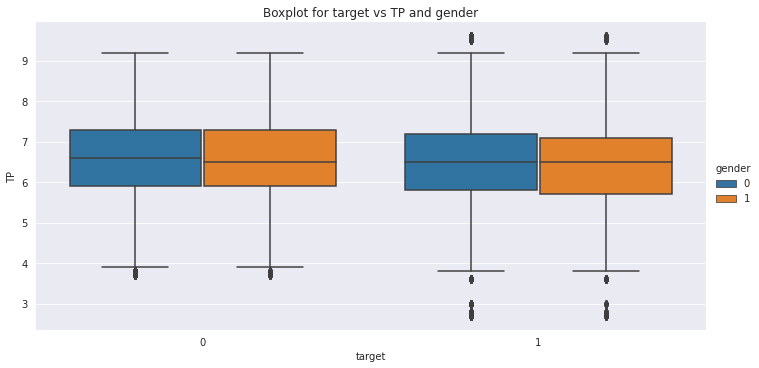

In [ ]:
# Box plot for TP 
sns.catplot(data=df.toPandas(), x="target", y="TP", hue="gender", kind="box", aspect=2)
plt.title("Boxplot for target vs TP and gender")
plt.show()

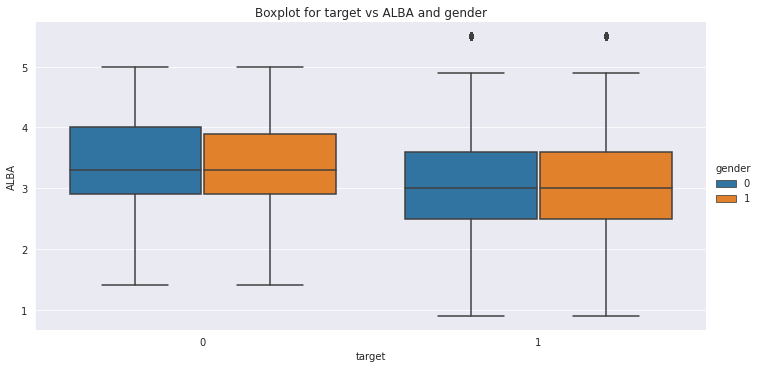

In [ ]:
# Box plot for ALBA 
sns.catplot(data=df.toPandas(), x="target", y="ALBA", hue="gender", kind="box", aspect=2)
plt.title("Boxplot for target vs ALBA and gender")
plt.show()

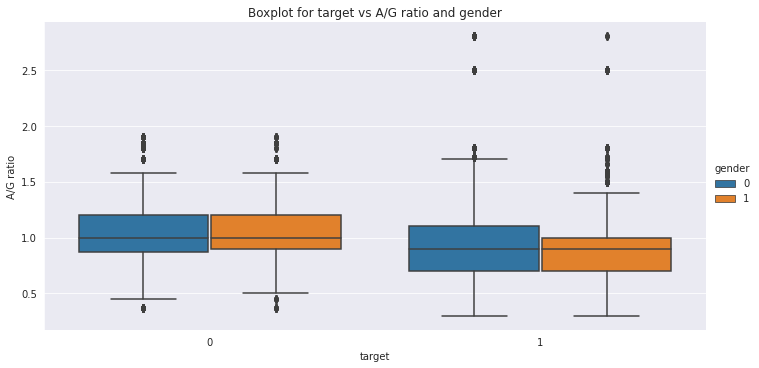

In [ ]:
# Box plot for A/G ratio 
sns.catplot(data=df.toPandas(), x="target", y="A/G ratio", hue="gender", kind="box", aspect=2)
plt.title("Boxplot for target vs A/G ratio and gender")
plt.show()

From the boxplots above of all the features we can see that there isn't a significant impact of the gender feature. 

Therefore, we will keep the data as is and won't split it into female and male.

## Univariate analysis of explanatory variables

In order to determine which variables will enter the ML model, two main parameters in each variable were tested in a one-dimensional analysis:

1. The amount of observations in each category.
2. The failure rates in each category.

According to the two parameters above, the categories were built in each variable and they were grouped/united so as to contain the amount of observations and the amount of essential failures.

Variables in which there was a good distinction in the failure rates, i.e. a continuous decrease/increase in the failure rates between the categories and a non-negligible amount of observations, were then tested in the ML models to examine their significance and the degree of correlation between them.

### Features histograms

<Figure size 2160x2160 with 0 Axes>

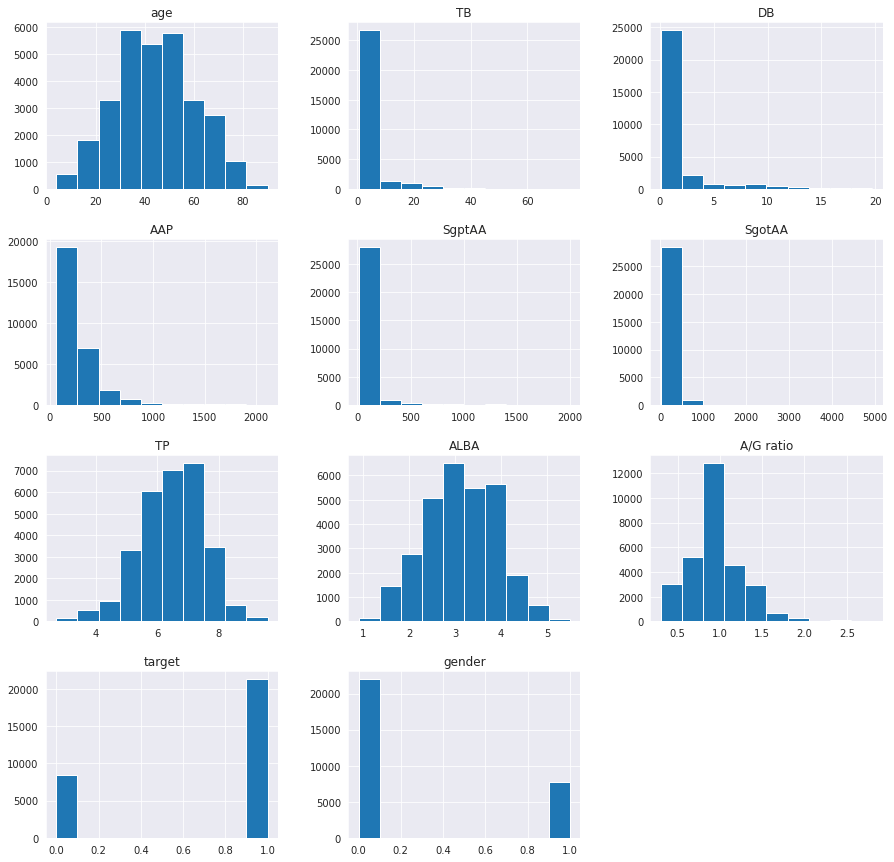

In [ ]:
plt.figure(figsize=(30,30))
df.toPandas().hist(figsize=(15,15))
plt.title("Features histograms")
plt.show()

### **Age** one-dimensional analysis

In [ ]:
# Define age bins
age_splits = [0,10,20,30,40,50,60,70,80, float('inf')]
age_labels = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','90+']

# Create Bucketizer object
bucketizer = Bucketizer(splits=age_splits, inputCol="age", outputCol="age_group")

# Apply bucketizer to dataframe
df = bucketizer.transform(df)

# Convert age group to string type
df = df.withColumn("age_group", df["age_group"].cast("string"))

# Replace null values with "Unknown"
df = df.fillna({'age_group': 'Unknown'})

# Show DataFrame
df.show(5)

+---+----+---+---+------+------+---+----+---------+------+------+---------+
|age|  TB| DB|AAP|SgptAA|SgotAA| TP|ALBA|A/G ratio|target|gender|age_group|
+---+----+---+---+------+------+---+----+---------+------+------+---------+
| 65| 0.7|0.1|187|    16|    18|6.8| 3.3|      0.9|     1|     1|      6.0|
| 62|10.9|5.5|699|    64|   100|7.5| 3.2|     0.74|     1|     0|      6.0|
| 62| 7.3|4.1|490|    60|    68|7.0| 3.3|     0.89|     1|     0|      6.0|
| 58| 1.0|0.4|182|    14|    20|6.8| 3.4|      1.0|     1|     0|      5.0|
| 72| 3.9|2.0|195|    27|    59|7.3| 2.4|      0.4|     1|     0|      7.0|
+---+----+---+---+------+------+---+----+---------+------+------+---------+
only showing top 5 rows



In [ ]:
df_age=df.groupby('age_group').agg(count('*').alias('amount of observations'),\
                                   sum('target').alias('amount of failures')).orderBy('age_group')
df_age.show()

+---------+----------------------+------------------+
|age_group|amount of observations|amount of failures|
+---------+----------------------+------------------+
|      0.0|                   268|               194|
|      1.0|                  1553|              1108|
|      2.0|                  3789|              2686|
|      3.0|                  6086|              4326|
|      4.0|                  6978|              5022|
|      5.0|                  5028|              3591|
|      6.0|                  4152|              2969|
|      7.0|                  1788|              1295|
|      8.0|                   145|               102|
+---------+----------------------+------------------+



In [ ]:
from pyspark.sql.window import Window

df_age.withColumn('failure rate', func.round(((df_age['amount of failures']/df_age['amount of observations']) * 100),2))\
      .withColumn('observations rate', func.round((F.col('amount of failures')/F.sum('amount of failures').over(Window.partitionBy()) * 100),2)).show()

+---------+----------------------+------------------+------------+-----------------+
|age_group|amount of observations|amount of failures|failure rate|observations rate|
+---------+----------------------+------------------+------------+-----------------+
|      0.0|                   268|               194|       72.39|             0.91|
|      1.0|                  1553|              1108|       71.35|              5.2|
|      2.0|                  3789|              2686|       70.89|            12.61|
|      3.0|                  6086|              4326|       71.08|            20.32|
|      4.0|                  6978|              5022|       71.97|            23.59|
|      5.0|                  5028|              3591|       71.42|            16.86|
|      6.0|                  4152|              2969|       71.51|            13.94|
|      7.0|                  1788|              1295|       72.43|             6.08|
|      8.0|                   145|               102|       70.34

We can see that there is no clear trend in the data that can identify a the relations between age and the target value.


### **TB** one-dimensional analysis

In [ ]:
# Define TB bins
TB_splits = [0.4,1.2, float('inf')]
TB_labels = ['0.4-1.2','1.3+']

# Create Bucketizer object
bucketizer = Bucketizer(splits=TB_splits, inputCol="TB", outputCol="TB_group")

# Apply bucketizer to dataframe
df = bucketizer.transform(df)

# Convert TB group to string type
df = df.withColumn("TB_group", df["TB_group"].cast("string"))

# Replace null values with "Unknown"
df = df.fillna({'TB_group': 'Unknown'})

# Show DataFrame
df.show(5)

+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+
|age|  TB| DB|AAP|SgptAA|SgotAA| TP|ALBA|A/G ratio|target|gender|age_group|TB_group|
+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+
| 65| 0.7|0.1|187|    16|    18|6.8| 3.3|      0.9|     1|     1|      6.0|     0.0|
| 62|10.9|5.5|699|    64|   100|7.5| 3.2|     0.74|     1|     0|      6.0|     1.0|
| 62| 7.3|4.1|490|    60|    68|7.0| 3.3|     0.89|     1|     0|      6.0|     1.0|
| 58| 1.0|0.4|182|    14|    20|6.8| 3.4|      1.0|     1|     0|      5.0|     0.0|
| 72| 3.9|2.0|195|    27|    59|7.3| 2.4|      0.4|     1|     0|      7.0|     1.0|
+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+
only showing top 5 rows



In [ ]:
df_TB=df.groupby('TB_group').agg(count('*').alias('amount of observations'),\
                                 sum('target').alias('amount of failures')).orderBy('TB_group')
df_TB.show()

+--------+----------------------+------------------+
|TB_group|amount of observations|amount of failures|
+--------+----------------------+------------------+
|     0.0|                 16218|              9743|
|     1.0|                 13569|             11550|
+--------+----------------------+------------------+



In [ ]:
from pyspark.sql.window import Window

df_TB.withColumn('failure rate', func.round(((df_TB['amount of failures']/df_TB['amount of observations']) * 100),2))\
      .withColumn('observations rate', func.round((F.col('amount of failures')/F.sum('amount of failures').over(Window.partitionBy()) * 100),2)).show()

+--------+----------------------+------------------+------------+-----------------+
|TB_group|amount of observations|amount of failures|failure rate|observations rate|
+--------+----------------------+------------------+------------+-----------------+
|     0.0|                 16218|              9743|       60.08|            45.76|
|     1.0|                 13569|             11550|       85.12|            54.24|
+--------+----------------------+------------------+------------+-----------------+



We can see a straight relationship between TB and the target variable. <br>
When TB is greater than 1.2 (not in the normal limit) the chances to diagnose liver disease are much higher.

### **DB** one-dimensional analysis

In [ ]:
# Define DB bins
DB_splits = [0.1,0.3,1.6, float('inf')]
DB_labels = ['0.1-0.3','0.4-1.6','1.7+']

# Create Bucketizer object
bucketizer = Bucketizer(splits=DB_splits, inputCol="DB", outputCol="DB_group")

# Apply bucketizer to dataframe
df = bucketizer.transform(df)

# Convert DB group to string type
df = df.withColumn("DB_group", df["DB_group"].cast("string"))

# Replace null values with "Unknown"
df = df.fillna({'DB_group': 'Unknown'})

# Show DataFrame
df.show(5)

+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+
|age|  TB| DB|AAP|SgptAA|SgotAA| TP|ALBA|A/G ratio|target|gender|age_group|TB_group|DB_group|
+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+
| 65| 0.7|0.1|187|    16|    18|6.8| 3.3|      0.9|     1|     1|      6.0|     0.0|     0.0|
| 62|10.9|5.5|699|    64|   100|7.5| 3.2|     0.74|     1|     0|      6.0|     1.0|     2.0|
| 62| 7.3|4.1|490|    60|    68|7.0| 3.3|     0.89|     1|     0|      6.0|     1.0|     2.0|
| 58| 1.0|0.4|182|    14|    20|6.8| 3.4|      1.0|     1|     0|      5.0|     0.0|     1.0|
| 72| 3.9|2.0|195|    27|    59|7.3| 2.4|      0.4|     1|     0|      7.0|     1.0|     2.0|
+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+
only showing top 5 rows



In [ ]:
df_DB=df.groupby('DB_group').agg(count('*').alias('amount of observations'),\
                                 sum('target').alias('amount of failures')).orderBy('DB_group')
df_DB.show()

+--------+----------------------+------------------+
|DB_group|amount of observations|amount of failures|
+--------+----------------------+------------------+
|     0.0|                 12735|              7478|
|     1.0|                 10739|              7795|
|     2.0|                  6313|              6020|
+--------+----------------------+------------------+



In [ ]:
df_DB.withColumn('failure rate', func.round(((df_DB['amount of failures']/df_DB['amount of observations']) * 100),2))\
      .withColumn('observations rate', func.round((F.col('amount of failures')/F.sum('amount of failures').over(Window.partitionBy()) * 100),2)).show()

+--------+----------------------+------------------+------------+-----------------+
|DB_group|amount of observations|amount of failures|failure rate|observations rate|
+--------+----------------------+------------------+------------+-----------------+
|     0.0|                 12735|              7478|       58.72|            35.12|
|     1.0|                 10739|              7795|       72.59|            36.61|
|     2.0|                  6313|              6020|       95.36|            28.27|
+--------+----------------------+------------------+------------+-----------------+



We can see a good distinction in the diagnostic liver disease rates.<br>
There is a clear increase in the diagnostic of having a liver disease whith the increse of DB levels and a non-negligible amount of observations

### **AAP** one-dimensional analysis

In [ ]:
# Define AAP bins
AAP_splits = [63,147, float('inf')]
AAP_labels = ['63-147','147+']

# Create Bucketizer object
bucketizer = Bucketizer(splits=AAP_splits, inputCol="AAP", outputCol="AAP_group")

# Apply bucketizer to dataframe
df = bucketizer.transform(df)

# Convert AAP group to string type
df = df.withColumn("AAP_group", df["AAP_group"].cast("string"))

# Replace null values with "Unknown"
df = df.fillna({'AAP_group': 'Unknown'})

# Show DataFrame
df.show(5)

+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+---------+
|age|  TB| DB|AAP|SgptAA|SgotAA| TP|ALBA|A/G ratio|target|gender|age_group|TB_group|DB_group|AAP_group|
+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+---------+
| 65| 0.7|0.1|187|    16|    18|6.8| 3.3|      0.9|     1|     1|      6.0|     0.0|     0.0|      1.0|
| 62|10.9|5.5|699|    64|   100|7.5| 3.2|     0.74|     1|     0|      6.0|     1.0|     2.0|      1.0|
| 62| 7.3|4.1|490|    60|    68|7.0| 3.3|     0.89|     1|     0|      6.0|     1.0|     2.0|      1.0|
| 58| 1.0|0.4|182|    14|    20|6.8| 3.4|      1.0|     1|     0|      5.0|     0.0|     1.0|      1.0|
| 72| 3.9|2.0|195|    27|    59|7.3| 2.4|      0.4|     1|     0|      7.0|     1.0|     2.0|      1.0|
+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+---------+
only showing top 5 rows



In [ ]:
df_AAP=df.groupby('AAP_group').agg(count('*').alias('amount of observations'),\
                                   sum('target').alias('amount of failures')).orderBy('AAP_group')
df_AAP.show()

+---------+----------------------+------------------+
|AAP_group|amount of observations|amount of failures|
+---------+----------------------+------------------+
|      0.0|                  2726|              1558|
|      1.0|                 27061|             19735|
+---------+----------------------+------------------+



In [ ]:
df_AAP.withColumn('failure rate', func.round(((df_AAP['amount of failures']/df_AAP['amount of observations']) * 100),2))\
      .withColumn('observations rate', func.round((F.col('amount of failures')/F.sum('amount of failures').over(Window.partitionBy()) * 100),2)).show(100)

+---------+----------------------+------------------+------------+-----------------+
|AAP_group|amount of observations|amount of failures|failure rate|observations rate|
+---------+----------------------+------------------+------------+-----------------+
|      0.0|                  2726|              1558|       57.15|             7.32|
|      1.0|                 27061|             19735|       72.93|            92.68|
+---------+----------------------+------------------+------------+-----------------+



We can see a straight relationship between AAP and the target variable. <br>
When AAP is greater than 147 (not in the normal limit) the chances to diagnose liver disease are much higher.

### **SgptAA** one-dimensional analysis

In [ ]:
# Define SgptAA bins
SgptAA_splits = [10,36, float('inf')]
SgptAA_labels = ['10-36','36+']

# Create Bucketizer object
bucketizer = Bucketizer(splits=SgptAA_splits, inputCol="SgptAA", outputCol="SgptAA_group")

# Apply bucketizer to dataframe
df = bucketizer.transform(df)

# Convert SgptAA group to string type
df = df.withColumn("SgptAA_group", df["SgptAA_group"].cast("string"))

# Replace null values with "Unknown"
df = df.fillna({'SgptAA_group': 'Unknown'})

# Show DataFrame
df.show(5)

+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+---------+------------+
|age|  TB| DB|AAP|SgptAA|SgotAA| TP|ALBA|A/G ratio|target|gender|age_group|TB_group|DB_group|AAP_group|SgptAA_group|
+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+---------+------------+
| 65| 0.7|0.1|187|    16|    18|6.8| 3.3|      0.9|     1|     1|      6.0|     0.0|     0.0|      1.0|         0.0|
| 62|10.9|5.5|699|    64|   100|7.5| 3.2|     0.74|     1|     0|      6.0|     1.0|     2.0|      1.0|         1.0|
| 62| 7.3|4.1|490|    60|    68|7.0| 3.3|     0.89|     1|     0|      6.0|     1.0|     2.0|      1.0|         1.0|
| 58| 1.0|0.4|182|    14|    20|6.8| 3.4|      1.0|     1|     0|      5.0|     0.0|     1.0|      1.0|         0.0|
| 72| 3.9|2.0|195|    27|    59|7.3| 2.4|      0.4|     1|     0|      7.0|     1.0|     2.0|      1.0|         0.0|
+---+----+---+---+------+------+---+----+---------+------+------

In [ ]:
df_SgptAA=df.groupby('SgptAA_group').agg(count('*').alias('amount of observations'),\
                                   sum('target').alias('amount of failures')).orderBy('SgptAA_group')
df_SgptAA.show()

+------------+----------------------+------------------+
|SgptAA_group|amount of observations|amount of failures|
+------------+----------------------+------------------+
|         0.0|                 14726|              8786|
|         1.0|                 15061|             12507|
+------------+----------------------+------------------+



In [ ]:
df_SgptAA.withColumn('failure rate', func.round(((df_SgptAA['amount of failures']/df_SgptAA['amount of observations']) * 100),2))\
         .withColumn('observations rate', func.round((F.col('amount of failures')/F.sum('amount of failures').over(Window.partitionBy()) * 100),2)).show(100)

+------------+----------------------+------------------+------------+-----------------+
|SgptAA_group|amount of observations|amount of failures|failure rate|observations rate|
+------------+----------------------+------------------+------------+-----------------+
|         0.0|                 14726|              8786|       59.66|            41.26|
|         1.0|                 15061|             12507|       83.04|            58.74|
+------------+----------------------+------------------+------------+-----------------+



We can see a straight relationship between SgptAA and the target variable. <br>
When SgptAA is greater than 36 (not in the normal limit) the chances to diagnose liver disease are much higher.

### **SgotAA** one-dimensional analysis

In [ ]:
# Define SgotAA bins
SgotAA_splits = [10,33, float('inf')]
SgotAA_labels = ['10-33','33+']

# Create Bucketizer object
bucketizer = Bucketizer(splits=SgotAA_splits, inputCol="SgotAA", outputCol="SgotAA_group")

# Apply bucketizer to dataframe
df = bucketizer.transform(df)

# Convert SgotAA group to string type
df = df.withColumn("SgotAA_group", df["SgotAA_group"].cast("string"))

# Replace null values with "Unknown"
df = df.fillna({'SgotAA_group': 'Unknown'})

# Show DataFrame
df.show(5)

+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+---------+------------+------------+
|age|  TB| DB|AAP|SgptAA|SgotAA| TP|ALBA|A/G ratio|target|gender|age_group|TB_group|DB_group|AAP_group|SgptAA_group|SgotAA_group|
+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+---------+------------+------------+
| 65| 0.7|0.1|187|    16|    18|6.8| 3.3|      0.9|     1|     1|      6.0|     0.0|     0.0|      1.0|         0.0|         0.0|
| 62|10.9|5.5|699|    64|   100|7.5| 3.2|     0.74|     1|     0|      6.0|     1.0|     2.0|      1.0|         1.0|         1.0|
| 62| 7.3|4.1|490|    60|    68|7.0| 3.3|     0.89|     1|     0|      6.0|     1.0|     2.0|      1.0|         1.0|         1.0|
| 58| 1.0|0.4|182|    14|    20|6.8| 3.4|      1.0|     1|     0|      5.0|     0.0|     1.0|      1.0|         0.0|         0.0|
| 72| 3.9|2.0|195|    27|    59|7.3| 2.4|      0.4|     1|     0|      7.0|     1.0|     2

In [ ]:
df_SgotAA=df.groupby('SgotAA_group').agg(count('*').alias('amount of observations'),\
                                   sum('target').alias('amount of failures')).orderBy('SgotAA_group')
df_SgotAA.show()

+------------+----------------------+------------------+
|SgotAA_group|amount of observations|amount of failures|
+------------+----------------------+------------------+
|         0.0|                 11068|              6355|
|         1.0|                 18719|             14938|
+------------+----------------------+------------------+



In [ ]:
df_SgotAA.withColumn('failure rate', func.round(((df_SgotAA['amount of failures']/df_SgotAA['amount of observations']) * 100),2))\
         .withColumn('observations rate', func.round((F.col('amount of failures')/F.sum('amount of failures').over(Window.partitionBy()) * 100),2)).show(100)

+------------+----------------------+------------------+------------+-----------------+
|SgotAA_group|amount of observations|amount of failures|failure rate|observations rate|
+------------+----------------------+------------------+------------+-----------------+
|         0.0|                 11068|              6355|       57.42|            29.85|
|         1.0|                 18719|             14938|        79.8|            70.15|
+------------+----------------------+------------------+------------+-----------------+



We can see a straight relationship between SgotAA and the target variable. <br>
When SgotAA is greater than 33 (not in the normal limit) the chances to diagnose liver disease are much higher.

### **TP** one-dimensional analysis

In [ ]:
# Define TP bins
TP_splits = [2.7,6.0,8.3, float('inf')]
TP_labels = ['2.7-5.9','6.0-8.3','8.3+']

# Create Bucketizer object
bucketizer = Bucketizer(splits=TP_splits, inputCol="TP", outputCol="TP_group")

# Apply bucketizer to dataframe
df = bucketizer.transform(df)

# Convert TP group to string type
df = df.withColumn("TP_group", df["TP_group"].cast("string"))

# Replace null values with "Unknown"
df = df.fillna({'TP_group': 'Unknown'})

# Show DataFrame
df.show(5)

+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+---------+------------+------------+--------+
|age|  TB| DB|AAP|SgptAA|SgotAA| TP|ALBA|A/G ratio|target|gender|age_group|TB_group|DB_group|AAP_group|SgptAA_group|SgotAA_group|TP_group|
+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+---------+------------+------------+--------+
| 65| 0.7|0.1|187|    16|    18|6.8| 3.3|      0.9|     1|     1|      6.0|     0.0|     0.0|      1.0|         0.0|         0.0|     1.0|
| 62|10.9|5.5|699|    64|   100|7.5| 3.2|     0.74|     1|     0|      6.0|     1.0|     2.0|      1.0|         1.0|         1.0|     1.0|
| 62| 7.3|4.1|490|    60|    68|7.0| 3.3|     0.89|     1|     0|      6.0|     1.0|     2.0|      1.0|         1.0|         1.0|     1.0|
| 58| 1.0|0.4|182|    14|    20|6.8| 3.4|      1.0|     1|     0|      5.0|     0.0|     1.0|      1.0|         0.0|         0.0|     1.0|
| 72| 3.9|2.0|195|    27|  

In [ ]:
df_TP=df.groupby('TP_group').agg(count('*').alias('amount of observations'),\
                                   sum('target').alias('amount of failures')).orderBy('TP_group')
df_TP.show()

+--------+----------------------+------------------+
|TP_group|amount of observations|amount of failures|
+--------+----------------------+------------------+
|     0.0|                  8610|              6266|
|     1.0|                 20207|             14343|
|     2.0|                   970|               684|
+--------+----------------------+------------------+



In [ ]:
df_TP.withColumn('failure rate', func.round(((df_TP['amount of failures']/df_TP['amount of observations']) * 100),2))\
         .withColumn('observations rate', func.round((F.col('amount of failures')/F.sum('amount of failures').over(Window.partitionBy()) * 100),2)).show(100)

+--------+----------------------+------------------+------------+-----------------+
|TP_group|amount of observations|amount of failures|failure rate|observations rate|
+--------+----------------------+------------------+------------+-----------------+
|     0.0|                  8610|              6266|       72.78|            29.43|
|     1.0|                 20207|             14343|       70.98|            67.36|
|     2.0|                   970|               684|       70.52|             3.21|
+--------+----------------------+------------------+------------+-----------------+



We can see that there is no clear trend in the data that can identify a the relations between TP and the target value.

### **ALBA** one-dimensional analysis

In [ ]:
# Define ALBA bins
ALBA_splits = [0.9,3.4, float('inf')]
ALBA_labels = ['0.9-3.4','3.5+']

# Create Bucketizer object
bucketizer = Bucketizer(splits=ALBA_splits, inputCol="ALBA", outputCol="ALBA_group")

# Apply bucketizer to dataframe
df = bucketizer.transform(df)

# Convert ALBA group to string type
df = df.withColumn("ALBA_group", df["ALBA_group"].cast("string"))

# Replace null values with "Unknown"
df = df.fillna({'ALBA_group': 'Unknown'})

# Show DataFrame
df.show(5)

+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+---------+------------+------------+--------+----------+
|age|  TB| DB|AAP|SgptAA|SgotAA| TP|ALBA|A/G ratio|target|gender|age_group|TB_group|DB_group|AAP_group|SgptAA_group|SgotAA_group|TP_group|ALBA_group|
+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+---------+------------+------------+--------+----------+
| 65| 0.7|0.1|187|    16|    18|6.8| 3.3|      0.9|     1|     1|      6.0|     0.0|     0.0|      1.0|         0.0|         0.0|     1.0|       0.0|
| 62|10.9|5.5|699|    64|   100|7.5| 3.2|     0.74|     1|     0|      6.0|     1.0|     2.0|      1.0|         1.0|         1.0|     1.0|       0.0|
| 62| 7.3|4.1|490|    60|    68|7.0| 3.3|     0.89|     1|     0|      6.0|     1.0|     2.0|      1.0|         1.0|         1.0|     1.0|       0.0|
| 58| 1.0|0.4|182|    14|    20|6.8| 3.4|      1.0|     1|     0|      5.0|     0.0|     1.0|      1

In [ ]:
df_ALBA=df.groupby('ALBA_group').agg(count('*').alias('amount of observations'),\
                                     sum('target').alias('amount of failures')).orderBy('ALBA_group')
df_ALBA.show()

+----------+----------------------+------------------+
|ALBA_group|amount of observations|amount of failures|
+----------+----------------------+------------------+
|       0.0|                 18328|             13997|
|       1.0|                 11459|              7296|
+----------+----------------------+------------------+



In [ ]:
df_ALBA.withColumn('failure rate', func.round(((df_ALBA['amount of failures']/df_ALBA['amount of observations']) * 100),2))\
         .withColumn('observations rate', func.round((F.col('amount of failures')/F.sum('amount of failures').over(Window.partitionBy()) * 100),2)).show(200)

+----------+----------------------+------------------+------------+-----------------+
|ALBA_group|amount of observations|amount of failures|failure rate|observations rate|
+----------+----------------------+------------------+------------+-----------------+
|       0.0|                 18328|             13997|       76.37|            65.74|
|       1.0|                 11459|              7296|       63.67|            34.26|
+----------+----------------------+------------------+------------+-----------------+



We can see a straight relationship between ALBA and the target variable. <br>
When ALBA is greater than 3.5 (not in the normal limit) the chances to diagnose liver disease are much higher.

### **A/G ratio** one-dimensional analysis

In [ ]:
# Define A/G ratio bins
AG_ratio_splits = [0.3,1.0,2.0, float('inf')]
AG_ratio_labels = ['0.3-1.0','1.1-2.0','2.1+']

# Create Bucketizer object
bucketizer = Bucketizer(splits=AG_ratio_splits, inputCol="A/G ratio", outputCol="AG_ratio_group")

# Apply bucketizer to dataframe
df = bucketizer.transform(df)

# Convert A/G ratio group to string type
df = df.withColumn("AG_ratio_group", df["AG_ratio_group"].cast("string"))

# Replace null values with "Unknown"
df = df.fillna({'AG_ratio_group': 'Unknown'})

# Show DataFrame
df.show(5)

+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+---------+------------+------------+--------+----------+--------------+
|age|  TB| DB|AAP|SgptAA|SgotAA| TP|ALBA|A/G ratio|target|gender|age_group|TB_group|DB_group|AAP_group|SgptAA_group|SgotAA_group|TP_group|ALBA_group|AG_ratio_group|
+---+----+---+---+------+------+---+----+---------+------+------+---------+--------+--------+---------+------------+------------+--------+----------+--------------+
| 65| 0.7|0.1|187|    16|    18|6.8| 3.3|      0.9|     1|     1|      6.0|     0.0|     0.0|      1.0|         0.0|         0.0|     1.0|       0.0|           0.0|
| 62|10.9|5.5|699|    64|   100|7.5| 3.2|     0.74|     1|     0|      6.0|     1.0|     2.0|      1.0|         1.0|         1.0|     1.0|       0.0|           0.0|
| 62| 7.3|4.1|490|    60|    68|7.0| 3.3|     0.89|     1|     0|      6.0|     1.0|     2.0|      1.0|         1.0|         1.0|     1.0|       0.0|           0.0|
| 58| 1.0|

In [ ]:
df_AG_ratio=df.groupby('AG_ratio_group').agg(count('*').alias('amount of observations'),\
                                   sum('target').alias('amount of failures')).orderBy('AG_ratio_group')
df_AG_ratio.show()

+--------------+----------------------+------------------+
|AG_ratio_group|amount of observations|amount of failures|
+--------------+----------------------+------------------+
|           0.0|                 15702|             12124|
|           1.0|                 13913|              8997|
|           2.0|                   172|               172|
+--------------+----------------------+------------------+



In [ ]:
df_AG_ratio.withColumn('failure rate', func.round(((df_AG_ratio['amount of failures']/df_AG_ratio['amount of observations']) * 100),2))\
         .withColumn('observations rate', func.round((F.col('amount of failures')/F.sum('amount of failures').over(Window.partitionBy()) * 100),2)).show(100)

+--------------+----------------------+------------------+------------+-----------------+
|AG_ratio_group|amount of observations|amount of failures|failure rate|observations rate|
+--------------+----------------------+------------------+------------+-----------------+
|           0.0|                 15702|             12124|       77.21|            56.94|
|           1.0|                 13913|              8997|       64.67|            42.25|
|           2.0|                   172|               172|       100.0|             0.81|
+--------------+----------------------+------------------+------------+-----------------+



We can see that there is no clear trend in the data that can identify a the relations between A/G ratio and the target value.

## Correlations

According to the methodology for developing statistical models, extremely high correlations should be avoided.

In order to verify independence, a correlation analysis is performed between all the explanatory variables, which were found to be significant.

A comparison is required with the values of the original risk characteristics.

The correlations between the explanatory variables in the model are at reasonable levels (lower than 40%) and do not require special attention.

A correlation above 40% would have indicated a high match between variables which would have required reference.


### Heatmap correlation

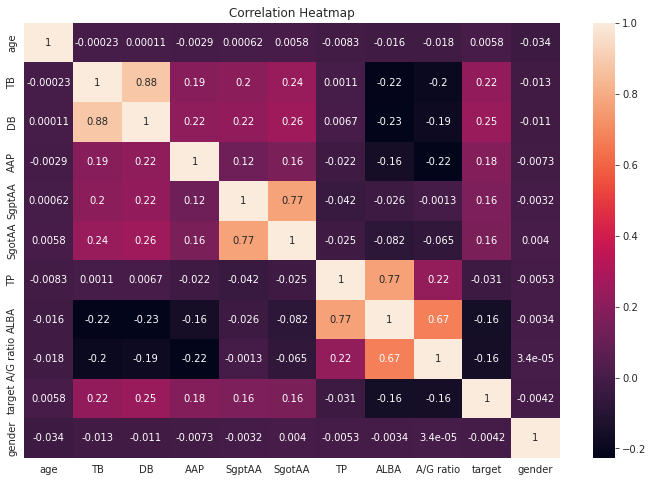

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.toPandas().corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

We can see from the above heatmap that there are 4 couples that have correlation above 40%: <br>


*   TB & DB
*   SgptAA & SgotAA 
*   TP & ALBA
*   ALBA & *A*/G ratio


## Pairplot correlation

### TB & DB correlation


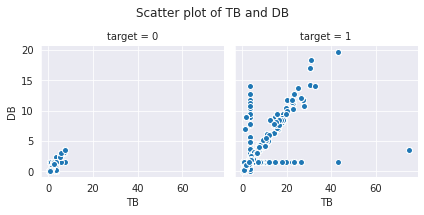

In [ ]:
g = sns.FacetGrid(df.toPandas(),col='target',margin_titles=True)
g.map(plt.scatter, 'TB','DB', edgecolor='w')
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Scatter plot of TB and DB')
plt.show()

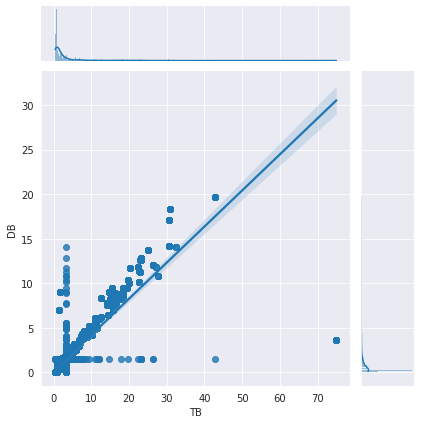

In [ ]:
sns.jointplot(x='TB',y='DB',data=df.toPandas(),kind='reg')
plt.show()

We can see that there is a linear relationship between DB and TB as the DB rises the TB rises as well. <br>
The marginal histograms are both right-skewed as most values are concentrated around the left side of the distribution while the right side of the distribution is longer. <br>
Outliers are the data points that lie far away from the rest of the data values, in the graph we can see outliers in the scatterplot as well as the histograms.

### SgptAA & SgotAA correlation

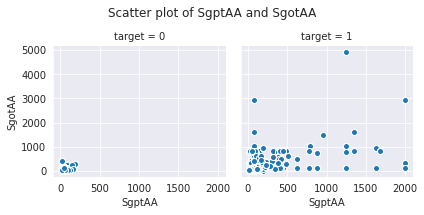

In [ ]:
g = sns.FacetGrid(df.toPandas(),col='target',margin_titles=True)
g.map(plt.scatter, 'SgptAA','SgotAA', edgecolor='w')
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Scatter plot of SgptAA and SgotAA')
plt.show()

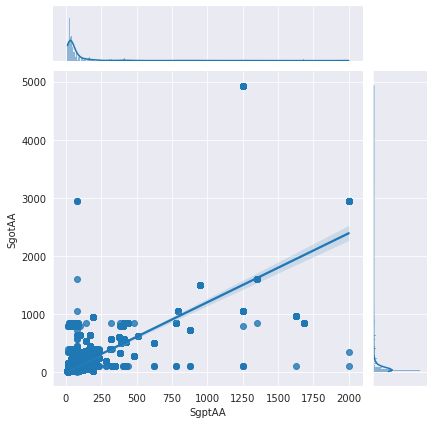

In [ ]:
sns.jointplot(x='SgptAA',y='SgotAA',data=df.toPandas(),kind='reg')
plt.show()

We can not really see the relationship between the variables. <br>
The marginal histograms are both right-skewed as most values are concentrated around the left side of the distribution while the right side of the distribution is longer.
Outliers are the data points that lie far away from the rest of the data values, in the graph we can see outliers in the scatterplot as well as the histograms.

### TP & ALBA correlation

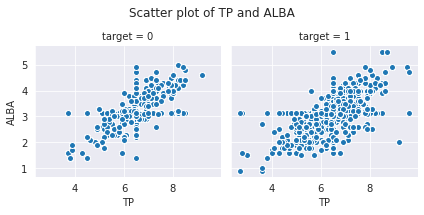

In [ ]:
g = sns.FacetGrid(df.toPandas(),col='target',margin_titles=True)
g.map(plt.scatter, 'TP','ALBA', edgecolor='w')
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Scatter plot of TP and ALBA')
plt.show()

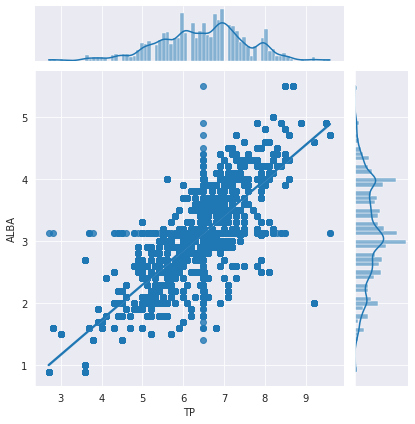

In [ ]:
sns.jointplot(x='TP',y='ALBA',data=df.toPandas(),kind='reg')
plt.show()

Observing the scatterplot above, there seems to be a positive relationship between the columns TP and ALBA because if the values of one variable increase so does the other.

The strength of the relationship appears to be moderate because the points are scattered in the graph.

### ALBA & A/G ratio

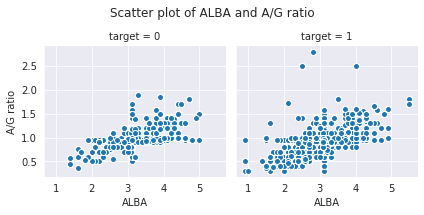

In [ ]:
g = sns.FacetGrid(df.toPandas(),col='target',margin_titles=True)
g.map(plt.scatter, 'ALBA','A/G ratio', edgecolor='w')
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Scatter plot of ALBA and A/G ratio')
plt.show()

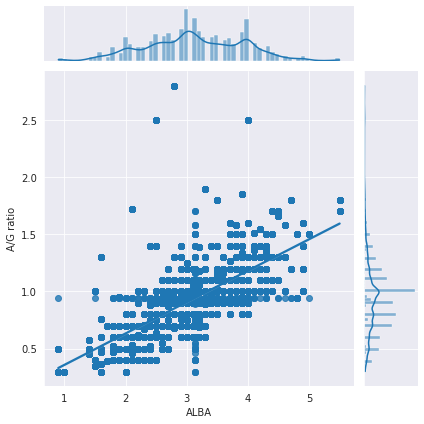

In [ ]:
sns.jointplot(x='ALBA',y='A/G ratio',data=df.toPandas(),kind='reg')
plt.show()

Observing the scatterplot above, there seems to be a positive relationship between the columns ALBA and A/G ratio because if the values of one variable increase so does the other.

The strength of the relationship appears to be moderate because the points are scattered in the graph.

## Conclusion of final features

From the above jointplots and scatterplots we find direct relationship between the following features:

*   TB & DB
*   SgptAA & SgotAA 
*   TP & ALBA
*   ALBA & A/G ratio

Hence, we can very well find that we can omit one of the features. We are going to keep the following features:

*   TB
*   SgptAA
*   TP
*   A/G ratio

Therefore, the final features that are going to be tested in the ML models:

*   Age
*   TB
*   AAP
*   SgptAA
*   TP
*   A/G ratio

### 

## Multidimensional analysis & Model Selection


We will test several ML models:


*   Logistic regression
*   Random forest
*   Gaussian Naive Bayes

We want to choose the best suited model for our particular problem.
So we will choose the model with the hightest AUC.

In healthcare we want to check the confiusion matrix, in particular the FN to be as smallest as possible.

We don't want to predict that a peitent doesn't have liver desis when he/she actualy has. 

So we will choose a the model that gives us the smallest value.

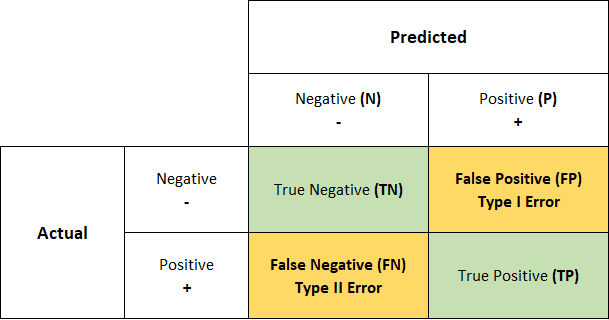

## Prepare the data for machine learning

In [ ]:
# Prepare the data for machine learning by assembling the feature columns into a vector
assembler = VectorAssembler(inputCols=['age', 'gender', 'TB', 'AAP', 'SgptAA', 'TP', 'A/G ratio'], outputCol="features", handleInvalid="skip")

data = assembler.transform(df).select("features", "target")

# Split the data into training and test sets
(trainingData, testData) = data.randomSplit([0.7, 0.3], seed=42)

#### Logistic Regression

In [ ]:
# Train a Logistic Regression Classifier model
lr_classifier = LogisticRegression(labelCol="target", featuresCol="features").fit(trainingData)

# Make predictions on the test data
lr_predictions = lr_classifier.transform(testData)

# Evaluate the model's performance
lr_auc = BinaryClassificationEvaluator(labelCol='target').evaluate(lr_predictions)
print("Logistic Regression Test AUC = %g" % lr_auc)

# Evaluate the model's performance
lr_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
lr_accuracy = lr_evaluator.evaluate(lr_predictions)
print("Logistic Regression Test Error = %g" % (1.0-lr_accuracy))

Logistic Regression Test AUC = 0.748967
Logistic Regression Test Error = 0.277233


Precision & Recall

In [ ]:
# evaluate the test predictions using MulticlassClassificationEvaluator
lr_precision = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "weightedPrecision"})
lr_recall = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "weightedRecall"})
lr_f1_score = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "f1"})
lr_support = lr_predictions.count()

# print the results
print("Logistic Regression Precision: ", lr_precision)
print("Logistic Regression Recall: ", lr_recall)
print("Logistic Regression F1-score: ", lr_f1_score)
print("Logistic Regression Support: ", lr_support)

Logistic Regression Precision:  0.6808598813571405
Logistic Regression Recall:  0.7227667004618678
Logistic Regression F1-score:  0.6516052998777921
Logistic Regression Support:  8877


Confusion matrix

In [ ]:
# Get the confusion matrix as a NumPy array
lr_confusion_matrix = lr_predictions.groupBy("target", "prediction").count().orderBy("target", "prediction").toPandas().pivot(index="target", columns="prediction", values="count").fillna(0).values


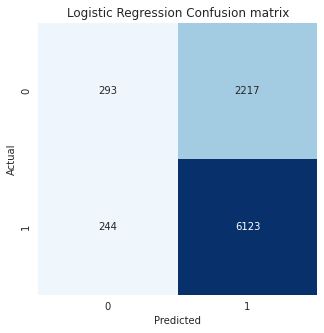

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(lr_confusion_matrix, annot=True, fmt="g", vmin=0, cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion matrix")
plt.show()

#### Random Forest

In [ ]:
# Train a Random Forest Classifier model
rf_classifier = RandomForestClassifier(labelCol="target", featuresCol="features", seed=42).fit(trainingData)

# Make predictions on the test data
rf_predictions = rf_classifier.transform(testData)

# Evaluate the model's performance
rf_auc = BinaryClassificationEvaluator(labelCol='target').evaluate(rf_predictions)
print("Random Forest Test AUC = %g" % rf_auc)

# Evaluate the model's performance
rf_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print("Random Forest Test Error = %g" % (1.0-rf_accuracy))

In [ ]:
rf_classifier.featureImportances

SparseVector(7, {2: 0.3345, 3: 0.222, 4: 0.2811, 5: 0.0766, 6: 0.0858})

Precision & Recall

In [ ]:
# evaluate the test predictions using MulticlassClassificationEvaluator
rf_precision = rf_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: "weightedPrecision"})
rf_recall = rf_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: "weightedRecall"})
rf_f1_score = rf_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: "f1"})
rf_support = rf_predictions.count()

# print the results
print("Random Forest Precision: ", rf_precision)
print("Random Forest Recall: ", rf_recall)
print("Random Forest F1-score: ", rf_f1_score)
print("Random Forest Support: ", rf_support)

Random Forest Precision:  0.7972576816754825
Random Forest Recall:  0.7946378280950772
Random Forest F1-score:  0.7651304490175225
Random Forest Support:  8877


Confusion matrix

In [ ]:
# Get the confusion matrix as a NumPy array
rf_confusion_matrix = rf_predictions.groupBy("target", "prediction").count().orderBy("target", "prediction").toPandas().pivot(index="target", columns="prediction", values="count").fillna(0).values


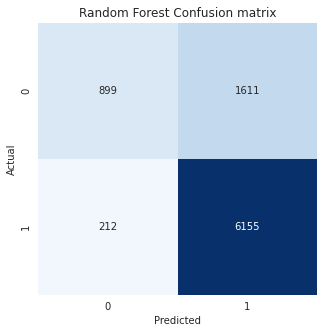

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(rf_confusion_matrix, annot=True, fmt="g", vmin=0, cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion matrix")
plt.show()

#### Gaussian Naive Bayes

In [ ]:
# Define the Gaussian Naive Bayes model and train the model on the training data
gnb_classifier = NaiveBayes(labelCol="target", featuresCol="features",smoothing=1.0, modelType="gaussian").fit(trainingData)

# Make predictions on the test data
gnb_predictions = gnb_classifier.transform(testData)

# Evaluate the model's performance
gnb_auc = BinaryClassificationEvaluator(labelCol='target').evaluate(gnb_predictions)
print("Gaussian Naive Bayes Test AUC = %g" % gnb_auc)

# Evaluate the model's performance
gnb_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
gnb_accuracy = gnb_evaluator.evaluate(gnb_predictions)
print("Gaussian Naive Bayes Test Error = %g" % (1.0-gnb_accuracy))

Gaussian Naive Bayes Test AUC = 0.437237
Gaussian Naive Bayes Test Error = 0.443168


Precision & Recall

In [ ]:
# Evaluate the performance of the model
gnb_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target", metricName="accuracy").evaluate(gnb_predictions)
print("Gaussian Naive Bayes Accuracy = %g" % gnb_accuracy)

gnb_precision = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target", metricName="weightedPrecision").evaluate(gnb_predictions)
print("Gaussian Naive Bayes Precision = %g" % gnb_precision)

gnb_recall = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target", metricName="weightedRecall").evaluate(gnb_predictions)
print("Gaussian Naive Bayes Recall = %g" % gnb_recall)

gnb_f1_score = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target", metricName="f1").evaluate(gnb_predictions)
print("Gaussian Naive Bayes F1 Score = %g" % gnb_f1_score)

Confusion matrix

In [ ]:
# Get the confusion matrix as a NumPy array
gnb_confusion_matrix = gnb_predictions.groupBy("target", "prediction").count().orderBy("target", "prediction").toPandas().pivot(index="target", columns="prediction", values="count").fillna(0).values


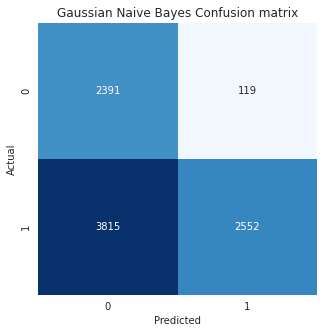

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(gnb_confusion_matrix, annot=True, fmt="g", vmin=0, cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gaussian Naive Bayes Confusion matrix")
plt.show()

In [ ]:
df_results = spark.createDataFrame(
         [("Random Forest",rf_auc,rf_precision,rf_recall,rf_f1_score),
          ("Logistic Regression",lr_auc,lr_precision,lr_recall,lr_f1_score),     
          ("Gaussian Naive Bayes",gnb_auc,gnb_precision,gnb_recall,gnb_f1_score)],
          
    ["ML model","AUC","Precision","Recall","F1-score"] 
)

df_results.toPandas()

We chose Random Forest	because it has the highest AUC and the lowest FN value.